In [12]:
# pip install iisignature
# pip install tqdm

In [1]:
import iisignature
import itertools
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.laguerre import laggauss
from scipy import integrate
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm
from numba import njit
import time
plt.style.use('ggplot')

In [2]:
#Returns: a list of tuples representing the words, sorted in graded lexicographic order.
def generate_words(alphabet, max_order, include_empty=True):
    """
    Génère les mots de l'alphabet donné jusqu'au max_order.

    Paramètres :
      - alphabet : liste ou tuple des symboles (par exemple [1, 2])
      - max_order : l'ordre maximum des mots (exclut le mot vide si include_empty=False)
      - include_empty : inclure le mot vide () au début (True par défaut)

    Retourne :
      - une liste de tuples représentant les mots dans l'ordre gradué lexicographique.
    """
    words = []
    if include_empty:
        words.append(())
    for order in range(1, max_order + 1):
        # itertools.product génère tous les produits cartésiens de longueur 'order'
        for word in itertools.product(alphabet, repeat=order):
            words.append(word)
    return words

In [3]:

def exp_shuffle(letter  , scalar , degree_max,words) :
  d={}
  for i in range(len(words)):
    d[words[i]]=0
  for i in range (degree_max) :
    d[(letter,)*i] = scalar **i
  return d

In [4]:
# Concatenates keys from two dictionaries and, if the concatenated key exists in the 'words' list,
# computes the product of their values and accumulates it in the result dictionary.
def concat(a , b ,words):
  result = {}
  for i in a.keys() :
    result[i]=0
  for item1 in a.keys() :
    for item2 in b.keys() :
      if item1+item2 in words :
        result[item1+item2]= result[item1+item2] + a[item1] * b[item2]
  return result

In [5]:
# Adds the values of two dictionaries with the same keys and returns a new dictionary with the summed values.
def add(a,b) :
  result = {}
  for key in a.keys() :
    result[key]=0
  for item in a.keys() :
    result[item] = a[item] + b[item]
  return result

In [6]:
# Generates an empty dictionary where the keys are all possible combinations of words
# created from an alphabet (range 1 to 'd') and a specified length 'm'. 
# Each key is initialized with a value of 0.
def create_empty(d,m) :
  alphabet = [i for i in range(1,d+1)]
  words = generate_words(alphabet, m)
  empty_dic={}
  for i in range(len(words)):
    empty_dic[words[i]]=0
  return empty_dic

In [7]:
# l_hat (sigma)
def l_hat_at_t(t,d,m,words):
  l_hat = create_empty(d,m)
  l_hat[()] = theta + np.exp(-kappa*t) * (x0-theta)
  word_2 =create_empty(d,m)
  word_2[(2,)] = eta * np.exp(-kappa * t)
  exp_shuffle_word = exp_shuffle(1,kappa,m,words)
  c=concat(exp_shuffle_word,word_2 , words)
  l_hat = add(l_hat, c)
  return l_hat


In [8]:
# Parameters
x0 = 0.2
kappa = 4
theta = 0.25
eta = 2
T = 1
dt = 0.005

# Number of time steps and time grid
N = int(T / dt)
t = np.linspace(0, T, N + 1)

# Number of Monte Carlo simulations
N_sim = 1000

In [9]:
# Each row corresponds to one simulation, each column to one time point
X_paths = np.zeros((N_sim, N + 1))
# Optionally, store the Brownian increments (each row for one simulation)
dW_matrix = np.zeros((N_sim, N))

# Monte Carlo simulation loop
for i in range(N_sim):
    # Generate Brownian increments for one simulation
    dW = np.sqrt(dt) * np.random.randn(N)
    dW_matrix[i, :] = dW

    # Initialize the OU process path for this simulation
    X = np.zeros(N + 1)
    X[0] = x0

    # Euler–Maruyama scheme for the OU process
    for j in range(1, N + 1):
        X[j] = X[j - 1] + kappa * (theta - X[j - 1]) * dt + eta * dW[j - 1]

    # Save the full path into the X_paths array
    X_paths[i, :] = X


# Optionally, calculate the mean path over time (averaging over simulations)
mean_path = np.mean(X_paths, axis=0)

dW=np.mean(dW_matrix,axis=0)
W = np.zeros(N + 1)
W[1:] = np.cumsum(dW)
path = np.column_stack((t, W))

In [10]:
def plot_ou(max_order, d):
    plt.figure(figsize=(10, 6))
    plt.plot(t, mean_path, label="MC PATH")
    alphabet = [i for i in range(1, d+1)]
    for m in range(2, max_order+1):
        words = generate_words(alphabet, m)
        l = l_hat_at_t(t, d, m, words)
        OU = np.zeros_like(t)
        OU[0] = x0
        signature_length = iisignature.siglength(d, m) + 1
        for i in range(1, N+1):
            signature = iisignature.sig(path[:i, :], m)
            dic = create_empty(d, m)
            dic[()] = 1
            for j in range(1, signature_length):
                dic[words[j]] = signature[j-1]
            S = 0
            l = l_hat_at_t(t[i], d, m, words)
            for key in dic.keys():
                S = S + l[key] * dic[key]
            OU[i] = S
        plt.plot(t, OU, label=str(m))
    plt.legend()
    plt.show()


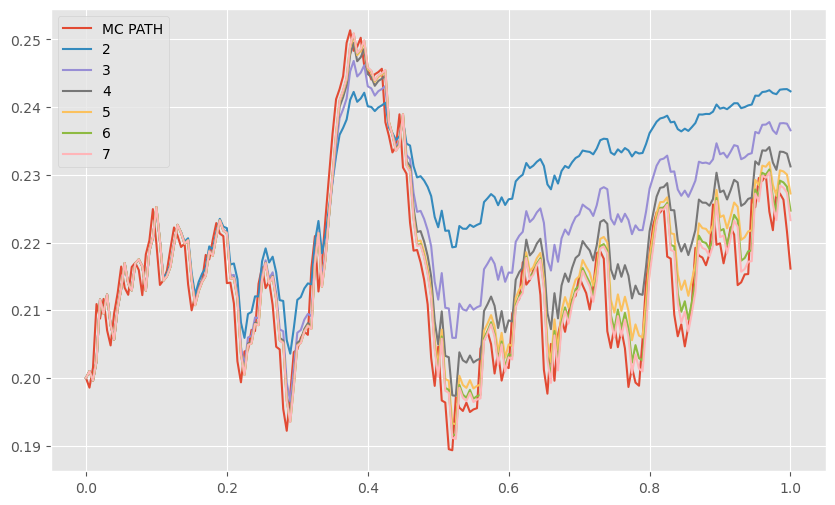

In [11]:
plot_ou(7,2)

Fourier

In [12]:
#Recursively compute the shuffle product of two words (tuples).
#Returns a dictionary mapping resulting words to combinatorial coefficients."
def shuffle_words(w1, w2):
    if not w1:
        return {w2: 1}
    if not w2:
        return {w1: 1}

    head1, tail1 = w1[0], w1[1:]
    head2, tail2 = w2[0], w2[1:]

    res = {}
    # Prepend head1 and shuffle the rest.
    for w, c in shuffle_words(tail1, w2).items():
        new_word = (head1,) + w
        res[new_word] = res.get(new_word, 0) + c
    # Prepend head2 and shuffle the rest.
    for w, c in shuffle_words(w1, tail2).items():
        new_word = (head2,) + w
        res[new_word] = res.get(new_word, 0) + c
    return res

In [13]:
def shuffle_presentation(a , b, d , m) :
  result= create_empty(d,m)
  for key_a in a.keys() :
    for key_b in b.keys() :
      if a[key_a] != 0 and b[key_b] != 0 :
        suffle = shuffle_words(key_a,key_b)
        for key_suffle in suffle.keys() :
          if key_suffle in result.keys() :
            result[key_suffle] += a[key_a] * b[key_b] * suffle[key_suffle]
  return result

In [14]:
def power_shuffle(a, power,d, m) :
  #assuming that power >= 2
  result = a
  # print("init:", result)
  if power >= 2 :
    for i in range(2,power+1) :
      result= shuffle_presentation(result , a , d , m)
      # print(i, " : ",result)
   # Return the final shuffled dictionary after completing all iterations.
  return result

In [15]:
def projection(a , word) :
  #word is a tuple can take {() , (1,) , (1,1), (2,)
  # a is dictionnaire of tuples
  result = {}
  for key in a.keys() :
    result[key] = 0
  word_len = len(word)
  for key in a.keys() :
    if len(key)>= word_len :
      if key[-word_len:] == word :
        result[key[:len(key)-word_len]] = a[key]
  #if a[word]!=0:
   # result[()]=a[word]
  return result

In [16]:
# return the multiplication of dictionnaire of a scalar
def scalar_mul(a , scalar) :
  result = {}
  for key in a.keys() :
    result[key] = scalar * a[key]
  return result

In [17]:
class fourier:
  def __init__(self,S0, K, maturity , n_steps  , M , d , x0 , kappa ,theta , rho,eta , verbose=False):
    self.verbose = verbose
    self.maturity = maturity
    self.K = K
    self.S0=S0
    self.n_steps = n_steps
    self.dt = (maturity) / n_steps
    self.t = np.linspace(0, maturity, n_steps + 1)
    self.t_inverse = np.linspace(self.t[-1], self.t[0], n_steps + 1)
    self.M = M
    self.M_tilde = 2 * self.M
    self.d = d
    self.alphabet = [i for i in range(1,self.d+1)]
    self.words_M =generate_words(self.alphabet, self.M)
    self.words =generate_words(self.alphabet, self.M_tilde)
    self.x0 =  x0
    self.kappa = kappa
    self.theta = theta
    self.rho = rho
    self.eta = eta
    self.sigma_bs = self.find_sigma_bs()
    

  def l_hat_at_t(self,t,d,m,words):
    l_hat = create_empty(self.d,self.M_tilde)
    l_hat[()] = self.theta + np.exp(-self.kappa*t) * (self.x0-self.theta)
    word_2 =create_empty(self.d,self.M_tilde)
    word_2[(2,)] = self.eta * np.exp(-self.kappa * t)
    exp_shuffle_word = exp_shuffle(1,self.kappa,self.M_tilde,self.words)
    c=concat(exp_shuffle_word,word_2 , self.words)
    l_hat = add(l_hat, c)
    return l_hat


  def sigma(self,t) :
    sigma_M= self.l_hat_at_t(t,self.d,self.M,self.words_M)
    sigma_M_tilde = create_empty(self.d,self.M_tilde)
    for key in sigma_M.keys() :
      sigma_M_tilde[key]=sigma_M[key]
    return sigma_M_tilde


  def F(self,psi, t, u):
    """
    Compute the right-hand side of the Riccati ODE at time t for a given u.

    The Riccati equation is:

      -ψ̇ = 0.5*(ψ^(2) ⊔ ψ^(2))
            + ρ f(t) (σ ⊔ ψ^(2))
            + 0.5 ψ^(2)
            + ψ^(1)
            + (f(t)/2 - f(t)^2 + g(t)) (σ ⊔ σ)

    with f(t)=i*u and g(t)=0.

    We extract the degree-1 and degree-2 parts of ψ.

    Returns: ψ̇ = -[RHS]
    """
    #rho = 0.5  # fixed parameter
    # f(t) = i*u (here constant in time)
    f_val = 1j * u
    g_val = 0.0

    psi_deg1 = projection(psi, (1,))
    psi_deg2 = projection(psi, (2,))
    psi_deg22 = projection(psi, (2,2))

    term1 = scalar_mul( power_shuffle(psi_deg2,2,self.d,self.M_tilde) , 0.5)

    term2 = scalar_mul(shuffle_presentation(self.sigma(t), psi_deg2 , self.d , self.M_tilde) , self.rho * f_val )

    term3 = scalar_mul( psi_deg22 , 0.5)

    term4 = psi_deg1

    coeff_term5 = 0.5*(f_val**2 - f_val) + g_val
    term5 = scalar_mul( power_shuffle(self.sigma(t), 2, self.d, self.M_tilde) , coeff_term5)

    total = add(add(term1, term2), add(term3, add(term4, term5)))

    # ODE is -ψ̇ = total, so ψ̇ = -total
    return scalar_mul(total, -1)

  def rk1(self,u):
    psy_inverse=[create_empty( self.d ,self.M_tilde) ]
    for i in range(self.n_steps):
        h = self.t_inverse[i+1] - self.t_inverse[i]
        step = scalar_mul(self.F(psy_inverse[i], self.t_inverse[i], u), h)
        y_next = add(psy_inverse[i], step)
        psy_inverse.append(y_next)
    return psy_inverse[-1]

  def phi(self , u) :
    psi_t = self.rk1(u)
    psi = psi_t[()]

    if self.verbose:
      print(" psi = ", psi)

    if (np.abs(np.real(psi)) < 200 and np.abs(np.imag(psi))<200):
      exp_psi = np.exp(psi)
    else:
      exp_psi = 1.0

    return exp_psi

  def BS_char_function(self, sigma_bs, u):
    return np.exp(-0.5*(sigma_bs**2)*(u**2+1j*u)*self.maturity)

  def BS_price(self, sigma_bs):
    d1 = (np.log(self.S0/ self.K)+sigma_bs**2*0.5*self.maturity)/(sigma_bs*np.sqrt(self.maturity))
    d2 = d1 - sigma_bs*np.sqrt(self.maturity)
    return self.S0*norm.cdf(d1) - self.K*norm.cdf(d2)

  def BS_cost_function(self, sigma_bs, reference_singature_cf_values, reference_u):
    error = 0
    for i in range(len(reference_singature_cf_values)):
      bs_cf = self.BS_char_function(sigma_bs, reference_u[i])
      error += np.array(bs_cf-reference_singature_cf_values[i]).real**2 + np.array(bs_cf-reference_singature_cf_values[i]).imag**2
    return np.sqrt(error/len(reference_singature_cf_values))

  def find_sigma_bs(self):
    init_sigma = np.array([self.x0])
    bounds = [(1e-6, 1.0)]
    reference_u = [0.0 - 0.5j, 0.125 - 0.5j, 0.25 - 0.5j, 0.5 - 0.5j, 1.0 - 0.5j, 2.0 - 0.5j, 5.0 - 0.5j, 10.0 - 0.5j, 15.0 - 0.5j]
    reference_singature_cf_values = [self.phi(u) for u in reference_u]

    optimize_solution = minimize(self.BS_cost_function, init_sigma, args=(reference_singature_cf_values, reference_u),method='SLSQP', bounds=bounds, tol=1e-25)
    solution = optimize_solution.x[0]
    if self.verbose:
      print("Calibrated BS Sigma = ", solution)
      print("Calibrated BS Price = ", self.BS_price(float(solution)))
    return float(solution)

  def lewis_integrand(self, u):
    """
    The integrand for Lewis's call price formula:

      f(u) = Re{ exp[i*(u - i/2)*ln(K)] * phi(u - i/2) } / (u^2 + 0.25)

    where phi is your characteristic function.
    """
    if (u < 120):
      # Shift u into the complex plane
      v = u - 0.5j
      # Compute the Fourier kernel
      # factor = np.exp(1j * v * np.log(self.S0/self.K))
      factor = np.exp(-1j * u * np.log(self.K))
      # Evaluate phi at the shifted argument
      control_variate = self.BS_char_function(self.sigma_bs, v)
      phi_val = self.phi(v)
      # Get the real part of the product
      numerator = np.real(factor * (phi_val-control_variate))
      integrand = numerator / (u**2 + 0.25)

    else:
      integrand = 0.0
    if self.verbose:
      print("Integrand(",u,") = ",integrand)
    return integrand

  def gauss_laguerre_integration(self, f, N=32):
    """
    Approximate the integral ∫₀∞ f(u) du using Gauss–Laguerre quadrature.
    """

    x, w = laggauss(N)
    total = 0.0
    i = 0
    for xi, wi in tqdm(zip(x, w)):
        i+=1
        if self.verbose:
          print("step =", i)
        total += wi * np.exp(xi) * f(xi)
    return total

  def call_price(self, N=32):
    """
    Computes the European call price using Lewis's formula combined
    with Gauss–Laguerre quadrature.
    """
    I = self.gauss_laguerre_integration(self.lewis_integrand, N)

    if self.verbose:
      print("integral =",I)
    price = self.BS_price(self.sigma_bs) - (np.sqrt(self.K) / np.pi) * I
    return price


In [18]:
# Option parameters
S0 = 1.0
K = [0.8, 0.9, 1.0, 1.1, 1.2]
maturity = 0.25

# Signature parameters
n_steps = 300
M=3
d=2

# Model parameters
x0 = 0.2
kappa = 1
theta = 0.25
eta = 1.2
rho= -0.5

## Generate Signature prices using Fourier pricing method

In [ ]:
signature_prices = []

for k in K:
    # Create the fourier object
    print("Started pricing for K=", k)
    fourier_model = fourier(S0, k, maturity, n_steps, M, d, x0, kappa, theta, rho, eta)
    print("Finished creating the fourier object and calibrating the BS sigma")
    # Calculate the call price
    call_price = fourier_model.call_price(N=96)
    print(f"Call price for K={k}: {call_price}")
    signature_prices.append(call_price)



Started pricing for K= 0.8
Finished creating the fourier object and calibrating the BS sigma
96it [22:57, 14.34s/it]
Call price for K=0.8: 0.22117873216665704
Started pricing for K= 0.9
Finished creating the fourier object and calibrating the BS sigma
96it [23:09, 14.47s/it]
Call price for K=0.9: 0.1407880571275989
Started pricing for K= 1.0
Finished creating the fourier object and calibrating the BS sigma
96it [23:14, 14.52s/it]
Call price for K=1.0: 0.07567731404965418
Started pricing for K= 1.1
Finished creating the fourier object and calibrating the BS sigma
96it [22:56, 14.33s/it]
Call price for K=1.1: 0.03397948365908465
Started pricing for K= 1.2
Finished creating the fourier object and calibrating the BS sigma
96it [23:21, 14.60s/it]
Call price for K=1.2: 0.014600867185505694


In [22]:
print("Signature prices: ", signature_prices)

Signature prices:  [0.22117873216665704, 0.1407880571275989, 0.07567731404965418, 0.03397948365908465, 0.014600867185505694]


## Generate prices using Monte-Carlo method

In [23]:
@njit
def stein_stein_mc_core(S0, sigma0, r, T, delta, theta, k, rho, K, N_half, M, option_type):
    """
    Core Numba-optimized simulation loop for Stein-Stein MC.
    Simulates N_half primary paths and N_half antithetic paths.
    """
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    one_minus_rho_sq_sqrt = np.sqrt(1 - rho**2)

    # Initialize arrays for results
    # We need N_half paths, each with M+1 time points
    P1 = np.empty((N_half, M + 1)) # Primary paths Price
    V1 = np.empty((N_half, M + 1)) # Primary paths Volatility
    P2 = np.empty((N_half, M + 1)) # Antithetic paths Price
    V2 = np.empty((N_half, M + 1)) # Antithetic paths Volatility

    # Set initial conditions
    P1[:, 0] = S0
    V1[:, 0] = sigma0
    P2[:, 0] = S0
    V2[:, 0] = sigma0

    # Generate all standard normal random numbers needed
    # Shape: (N_half paths, 2 dimensions (X1, X2), M steps)
    norm_rv = np.random.standard_normal((N_half, 2, M))

    # Time stepping loop
    for m in range(M):
        # Get random numbers for this step for all N_half paths
        X1 = norm_rv[:, 0, m]
        X2 = norm_rv[:, 1, m]

        # --- Correlated Normals (Z1, Z2) for Primary Path ---
        Z1_1 = X1
        Z2_1 = rho * X1 + one_minus_rho_sq_sqrt * X2

        # --- Correlated Normals (-Z1, -Z2) for Antithetic Path ---
        Z1_2 = -Z1_1
        Z2_2 = -Z2_1 # rho * (-X1) + sqrt(1-rho^2) * (-X2) = -Z2_1

        # --- Get volatility at start of step ---
        # Important: Use volatility at time m for updates to time m+1
        vol1_m = V1[:, m]
        vol2_m = V2[:, m]

        # --- Update Volatility (Euler + Absolute Value Correction) ---
        # Primary path
        V1[:, m+1] = vol1_m + delta * (theta - vol1_m) * dt + k * sqrt_dt * Z2_1
        # Antithetic path
        V2[:, m+1] = vol2_m + delta * (theta - vol2_m) * dt + k * sqrt_dt * Z2_2

        # --- Update Price (Euler Scheme) ---
        # Primary path
        P1[:, m+1] = P1[:, m] * (1 + r * dt + vol1_m * sqrt_dt * Z1_1)
        #P1[:, m+1] = P1[:, m] * np.exp(-0.5*vol1_m*dt + vol1_m * sqrt_dt * Z1_1) 
        # Antithetic path
        P2[:, m+1] = P2[:, m] * (1 + r * dt + vol2_m * sqrt_dt * Z1_2)
        #P2[:, m+1] = P2[:, m] * np.exp(-0.5*vol2_m*dt + vol2_m * sqrt_dt * Z1_2) 


    # Calculate Payoffs at maturity T
    final_P1 = P1[:, M]
    final_P2 = P2[:, M]

    if option_type == 'call':
        payoff1 = np.maximum(final_P1 - K, 0.0)
        payoff2 = np.maximum(final_P2 - K, 0.0)
    elif option_type == 'put':
        payoff1 = np.maximum(K - final_P1, 0.0)
        payoff2 = np.maximum(K - final_P2, 0.0)
    else:
        # Should not happen with prior checks, but good practice
        payoff1 = np.zeros(N_half)
        payoff2 = np.zeros(N_half)

    # Average payoff for each pair (primary + antithetic)
    # avg_payoffs = (payoff1 + payoff2) / 2.0

    # Calculate the Monte Carlo estimate (average of the pair averages)
    # mc_mean = np.mean(avg_payoffs)

    sum = np.sum(payoff1) + np.sum(payoff2)
    mc_mean = sum/(2*N_half)

    # Discount back to present value
    option_price = mc_mean * np.exp(-r * T)

    return option_price


def stein_stein_mc_antithetic(S0, sigma0, K, T, r, delta, theta, k, rho, N, M, option_type='call'):
    """
    Prices European options using the Stein-Stein model with Monte Carlo
    simulation, Euler-Maruyama scheme, and antithetic variance reduction.

    Args:
        S0 (float): Initial stock price.
        sigma0 (float): Initial volatility. Must be non-negative.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate.
        delta (float): Speed of mean reversion for volatility.
        theta (float): Long-run mean volatility level.
        k (float): Volatility of volatility ('vol of vol').
        rho (float): Correlation between asset price and volatility shocks.
        N (int): Total number of simulation paths desired (will be rounded up to nearest even number).
        M (int): Number of time steps for discretization.
        option_type (str): 'call' or 'put'.

    Returns:
        float: Estimated option price.
    """
    if sigma0 < 0:
        raise ValueError("Initial volatility sigma0 cannot be negative.")
    if option_type.lower() not in ['call', 'put']:
         raise ValueError("option_type must be 'call' or 'put'.")
    if N <= 0:
        raise ValueError("Number of paths N must be positive.")
    if M <= 0:
        raise ValueError("Number of time steps M must be positive.")

    # Ensure N is even for antithetic pairs
    if N % 2 != 0:
        N += 1
        print(f"Adjusted N to {N} for antithetic variates.")

    N_half = N // 2 # Number of pairs (primary + antithetic)

    start_time = time.time()

    # Call the Numba-optimized core function
    price = stein_stein_mc_core(S0, sigma0, r, T, delta, theta, k, rho, K, N_half, M, option_type.lower())

    end_time = time.time()
    print(f"Simulation completed in {end_time - start_time:.4f} seconds.")

    return price

In [24]:

# Option parameters
S0 = 1.0
K = [0.8, 0.9, 1.0, 1.1, 1.2]
T_val = 0.25 # maturity

# Simulation Parameters
N_paths = 1000000    # Total desired paths 
M_steps = 256       # Number of time steps per path

# Model parameters
sigma0_val = 0.20  #x0 = 0.2
delta_val = 1.0     # Speed of mean reversion kappa = 1
theta_val = 0.25    # Long-run volatility (25%) theta = 0.25
k_val = 1.2        # Volatility of volatility (30%) eta = 1.2
rho_val = -0.5      # Correlation

In [ ]:
monte_carlo_prices = []

for k in K:
    # Calculate the call price
    call_price = stein_stein_mc_antithetic(S0=S0, sigma0=sigma0_val, K=k, T=T_val, r=0.0,delta=delta_val, theta=theta_val, k=k_val, rho=rho_val,N=N_paths, M=M_steps, option_type='call')
    print(f"Call price for K={k}: {call_price}")
    monte_carlo_prices.append(call_price)

Simulation completed in 19.5604 seconds.
Call price for K=0.8: 0.2212449435816705
Simulation completed in 18.7433 seconds.
Call price for K=0.9: 0.14063467274047872
Simulation completed in 18.7894 seconds.
Call price for K=1.0: 0.07566280286200552
Simulation completed in 18.8411 seconds.
Call price for K=1.1: 0.033932832552451275
Simulation completed in 18.9570 seconds.
Call price for K=1.2: 0.01470130026623141


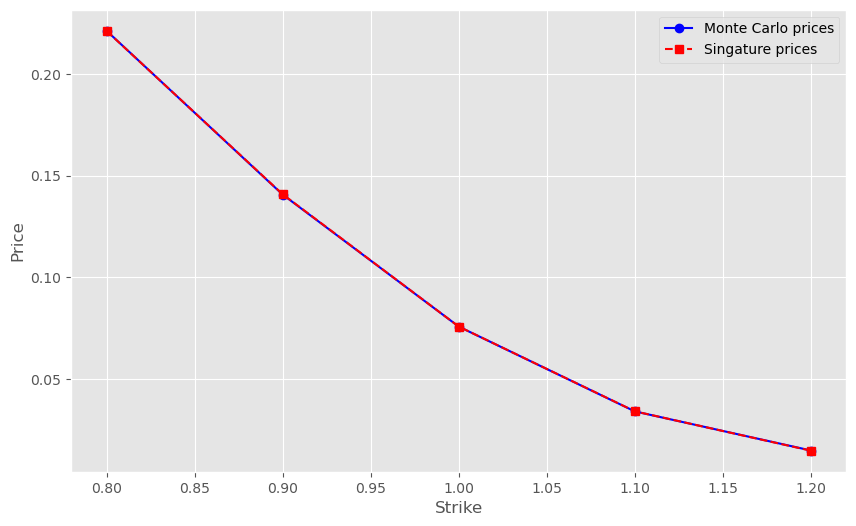

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(K, monte_carlo_prices, label='Monte Carlo prices', color='blue', linestyle='-', marker='o')
plt.plot(K, signature_prices, label='Singature prices', color='red', linestyle='--', marker='s')

plt.xlabel('Strike')
plt.ylabel('Price')

# Add legend
plt.legend()

# Show the plot
plt.show()